# Visualizations in R

Useful links
- [R Graph Gallery](https://www.r-graph-gallery.com)
- Libraries
    - [ggplot2](https://ggplot2.tidyverse.org)
    - [Plotly R](https://plotly.com/r/)


## Example data set
We'll be using a regulartory dataset that's made available to the public by the Home Mortgage Disclosure Act (HMDA). Congress enacted this legislation in 1975 in response to concerns about racial discrimination in mortgage financing. Each year thousands of mortgage financiers report almost every mortgage application they receive and the outcome of the loan (e.g., whether it was approved or rejected) along with some limited characteristics of the borrower(s) (e.g., race, ethnicity and gender) and some characteristics of the loan (e.g., interest rate, loan amount and length of the mortgage).

To learn more about the dataset, visit the Consumer Financial Protection Bureau (CFPB) [website](https://www.consumerfinance.gov/data-research/hmda/historic-data/), which hosts the public version for the HMDA data.

## Loading libraries
We'll load some libraries:
- **ggplot2**: Helpful library for making plots. Probably the most popular choice in R.
- **dplyr**: Helpful functions to manipulate data.
- **haven**: For loading `.dta` directly into R.
- **tidyr**: Manipulate data the tidyverse way.
- **labelled**: Manage labels from Stata datasets.

In [3]:
library(ggplot2)
library(dplyr)    
library(haven)    
library(tidyr)    
# Install and load package 'labelled'
if (!require("labelled")) install.packages("labelled")
library(labelled)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Loading the data
I've created a subset of the public dataset that has been compressed. The original dataset is 8.39 GB while this subset is just ~220 MB.

In [6]:
# Define a variable to store this long URL that links to the data on Dropbox.
HMDA_URL <- "https://www.dropbox.com/s/8atgvmsq5ulssi4/hmda2019_extract.dta?dl=1"

# Load the entire dataset into a data.frame (technically, tbl_df)
hmda <- read_dta(HMDA_URL)

# Let's take a look at the first few rows
head(hmda)

activity_year,state_code,census_tract,action_taken,loan_amount,combined_loan_to_value_ratio,interest_rate,rate_spread,loan_term,dwelling_category,mh_land_prop,race,ethnicity,gender,approved
<dbl>,<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
2019,SD,46055960100,1,55000,90.000,3.750,0.635,180,2,NA(n),9,5,3,1
2019,SD,46103011005,1,435000,68.661,4.000,-0.183,366,2,NA(n),9,5,2,1
2019,WY,56045951100,1,265000,95.000,4.000,0.169,360,2,NA(n),9,5,2,1
2019,SD,46103010903,1,235000,84.767,4.125,0.193,360,2,NA(n),9,5,2,1
2019,SD,46081966100,3,75000,80.000,NA,NA,360,2,NA(n),NA,NA,1,0
2019,SD,46103010904,1,135000,60.181,3.750,0.365,180,2,NA(n),9,5,2,1


## Scatter plot
Let's make a graph showing the disparity in interest rates between Black non-Latino and White Non-Latino borrowers by state.

In order to plot a scatter plot, we need two columns: one for the *x*-coordinate and one for the *y*-coordinate. Let's break down the steps we'll need to undertake:

- Restrict the sample to non-Latino Black and White borrowers.
- Calculate the mean interest rate spread for each group in each state.
- Reshape the data to have separate columns for each group.

In [18]:
#----------------------------------------#
# Data Prep: Disparity in interest rates #
#----------------------------------------#

# Restrict sample, collapse data and then reshape
rate_spread_disparity_black_white <- hmda %>%
filter(race %in% c(4, 9) & ethnicity == 5) %>%
group_by(state_code, race) %>%
summarize(
    mean_spread = mean(rate_spread, na.rm = TRUE),
    count_spread = sum(!is.na(rate_spread))
) %>%
ungroup() %>%
pivot_wider(
    names_from = race,
    values_from = c(mean_spread, count_spread)
)

# Print the first few rows
head(rate_spread_disparity_black_white)

`summarise()` has grouped output by 'state_code'. You can override using the `.groups` argument.



state_code,mean_spread_4,mean_spread_9,count_spread_4,count_spread_9
<chr>,<dbl>,<dbl>,<int>,<int>
AK,0.2449026,0.2855465,47,2942
AL,1.6857723,0.9095444,2966,26541
AR,1.6346101,0.8311179,806,15111
AZ,0.8514294,0.5684237,1336,52124
CA,0.6774095,0.3394266,4513,98262
CO,0.5619891,0.3482514,807,49485


Now let's make our first scatter plot. It's a starting point that we'll refine in further steps.

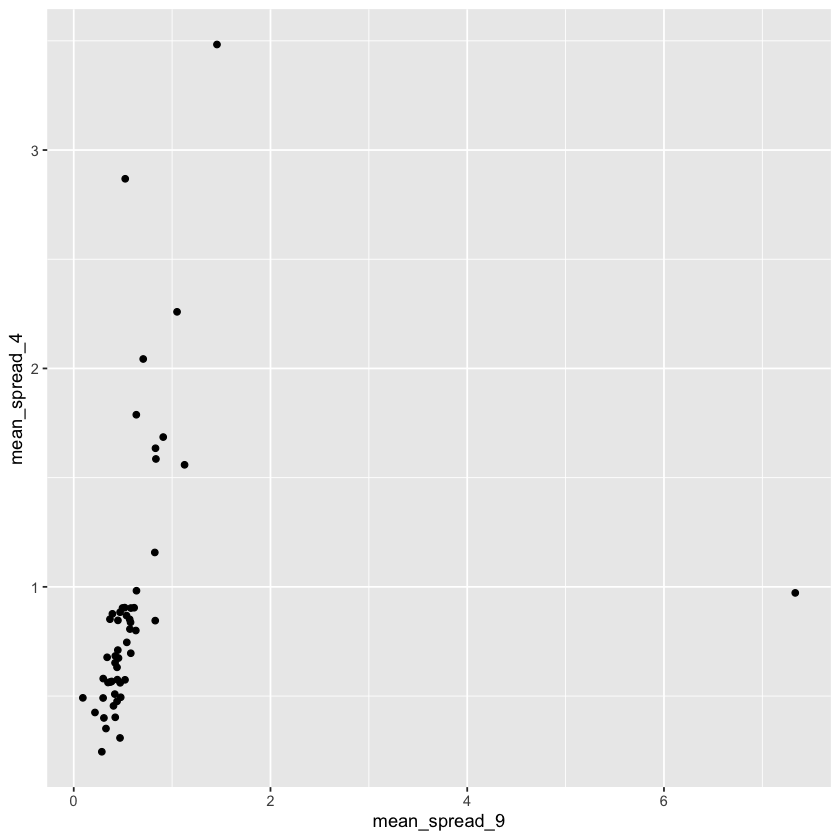

In [14]:
#-----------------------------------#
# Plot: Disparity in interest rates #
#-----------------------------------#

plt_disparity <- rate_spread_disparity_black_white %>%
  ggplot(aes(y = mean_spread_4, x = mean_spread_9)) +
  geom_point()

plt_disparity

Seems like we have a outlier for one of the states. Let's figure out what state it is.

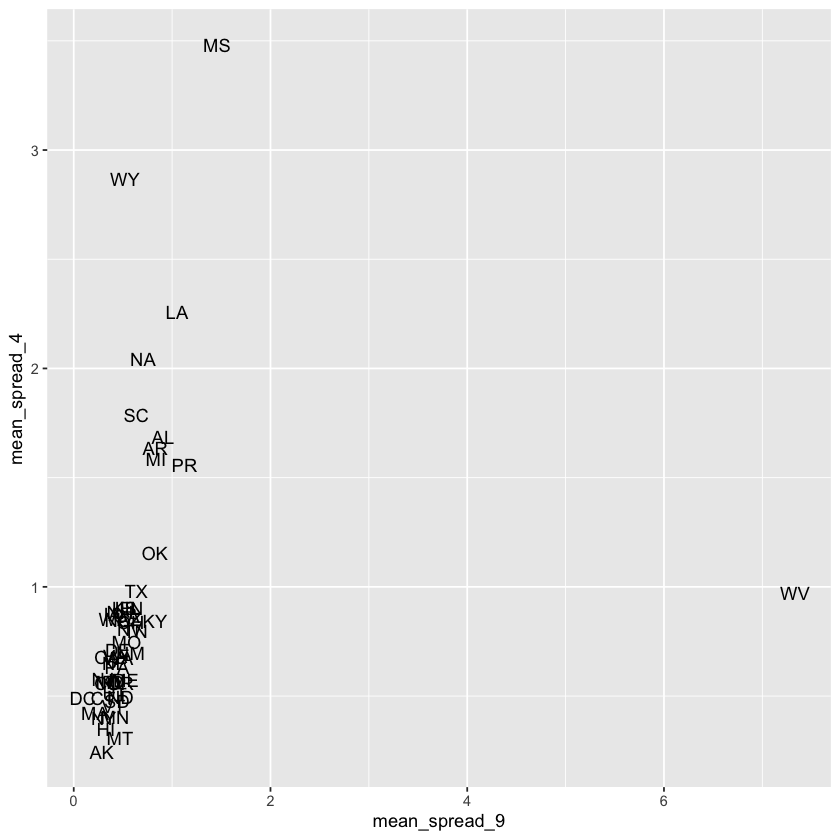

In [5]:
# Plot with labels

plt_disparity <- rate_spread_disparity_black_white %>%
  ggplot(aes(y = mean_spread_4, x = mean_spread_9)) +
  geom_text(aes(label = state_code), hjust = 0.5, vjust = 0.5)

plt_disparity

It's West Virgina! But what's going on? Let's take a look at the number of observations for West Virigina.

In [15]:
# Print 15 smallest counts of Black borrowers

rate_spread_disparity_black_white %>%
  arrange(count_spread_4) %>%
  head(n = 15)

state_code,mean_spread_4,mean_spread_9,count_spread_4,count_spread_9
<chr>,<dbl>,<dbl>,<int>,<int>
PR,1.5588000,1.1266551,5,176
WY,2.8683750,0.5233239,8,3183
MT,0.3082000,0.4704111,10,8254
VT,0.4549667,0.4040912,18,3922
ND,0.4944435,0.4775867,23,3523
SD,0.4758824,0.4404117,34,5179
ID,0.5750754,0.4433475,35,15155
HI,0.3512286,0.3276306,42,2557
ME,0.5743182,0.5211929,44,8426


In [7]:
# Print 15 smallest counts of White borrowers

rate_spread_disparity_black_white %>%
  arrange(count_spread_9) %>%
  head(n = 15)

state_code,mean_spread_4,mean_spread_9,count_spread_4,count_spread_9
<chr>,<dbl>,<dbl>,<int>,<int>
PR,1.5588000,1.12665511,5,176
HI,0.3512286,0.32763058,42,2557
NA,2.0433125,0.70624174,256,2937
AK,0.2449026,0.28554652,47,2942
WY,2.8683750,0.52332386,8,3183
DC,0.4917922,0.09265163,753,3362
ND,0.4944435,0.47758668,23,3523
VT,0.4549667,0.40409120,18,3922
SD,0.4758824,0.44041169,34,5179


There are some really small counts for some of the states. There are multiple ways to move forward. Maybe we should be using medians? Maybe there are some loan types with extreme values that we don't want to consider? For now, let's just restrict our plot to states with at least a 150 borrowers in each group.

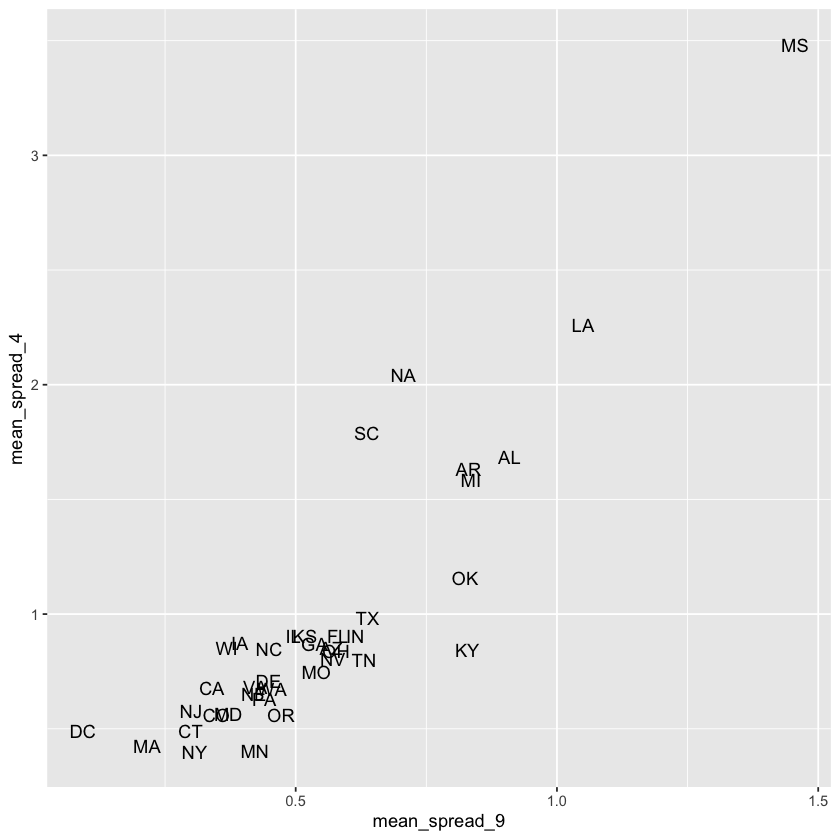

In [19]:
# Plot with labels states that have at least 150 borrowers

plt_disparity <- rate_spread_disparity_black_white %>%
  filter(count_spread_4 > 150 & count_spread_9 > 150) %>%
  ggplot(aes(y = mean_spread_4, x = mean_spread_9)) +
  geom_text(aes(label = state_code), hjust = 0.5, vjust = 0.5)

plt_disparity

We might want to emphasis data points with larger popluations. Let's allow the points to vary about the size of the total number of Black and White borrowers.

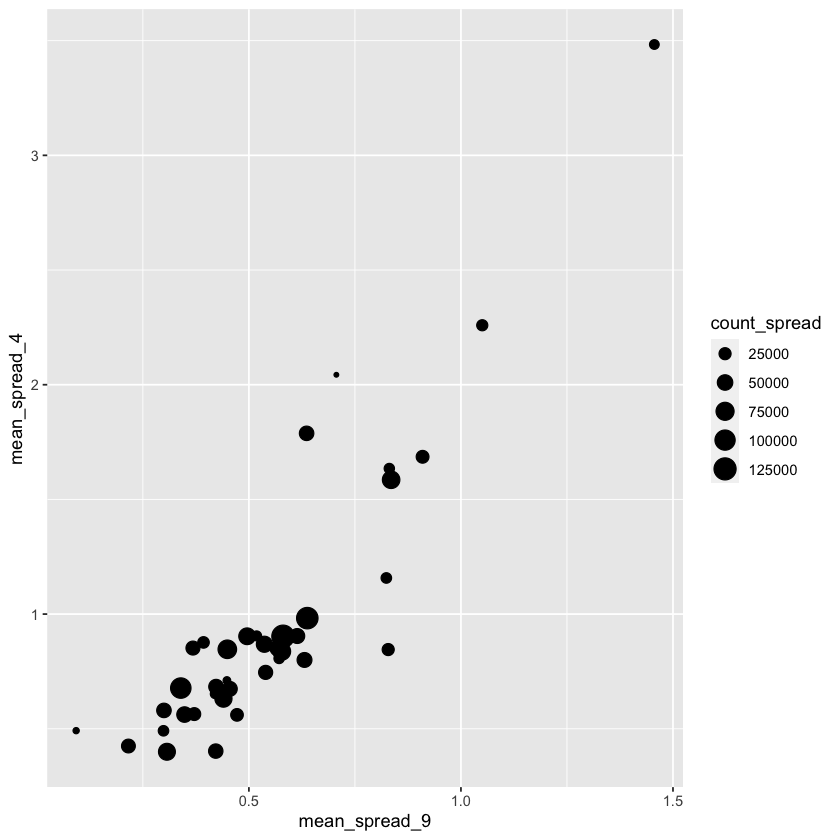

In [20]:
# Plot states with points varying with count size

plt_disparity <- rate_spread_disparity_black_white %>%
  filter(count_spread_4 > 150 & count_spread_9 > 150) %>%
  mutate(count_spread = count_spread_4 + count_spread_9) %>%
  ggplot(aes(y = mean_spread_4, x = mean_spread_9)) +
  geom_point(aes(size = count_spread))

plt_disparity

Let's put some final touches on this graph.

- Filter the state "NA."
- Use transparency in the points to deal with overlapping points.
- Remove legend.
- Reduce ink-to-data ratio.
- Make the *y* and *x* axis the same scale.
- Add a diagonal line.
- Add titles, labels, footnote and annotations.

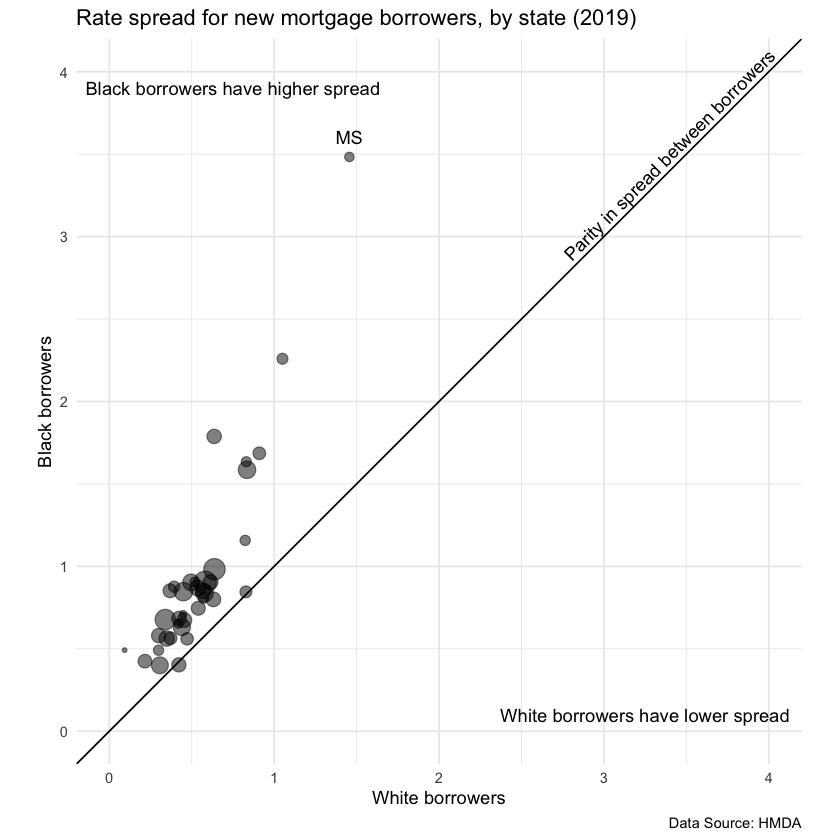

In [10]:
# Add additional details for a more publication-ready plot

plt_disparity <- rate_spread_disparity_black_white %>%
  filter(count_spread_4 > 150 & count_spread_9 > 150) %>%
  filter(state_code != "NA") %>%
  mutate(count_spread = count_spread_4 + count_spread_9) %>%
  mutate(outlier = ifelse(mean_spread_4 > 3, state_code, "")) %>%
  ggplot(aes(y = mean_spread_4, x = mean_spread_9)) +
  geom_point(aes(size = count_spread), alpha = 0.5) +
  geom_text(aes(label = outlier), vjust = -1, hjust = 0.5) +
  geom_abline() +
  coord_fixed() +
  labs(
    title = "Rate spread for new mortgage borrowers, by state (2019)",
    caption = "Data Source: HMDA",
    x = "White borrowers",
    y = "Black borrowers"
  ) +
  xlim(0, 4) +
  ylim(0, 4) +
  annotate(
      geom = "text",
      x = 0.75,
      y = 3.9,
      label = "Black borrowers have higher spread",
  ) +
  annotate(
      geom = "text",
      x = 3.25,
      y = 0.1,
      label = "White borrowers have lower spread"
  ) +
  annotate(
      geom = "text",
      x = 3.4,
      y = 3.5,
      label = "Parity in spread between borrowers",
      angle = 45
  ) +
  theme_minimal() +
  theme(legend.position = "none")

plt_disparity


Still lots more that could be done (e.g., change font to match report/presentation and/or increase font size for readability). More importantly, you'd want to spend more time digging into the details and focusing on understanding the narrative you're trying to tell with the graph. But this is a good start!

## Bar chart

For this next exercise, we'll be plotting a bar graph. Let's investigate the disparity in loan approval rates between manufactured homes and site-built homes. In particular, the HMDA data provides information on the whether the covered loan or application is, or would have been in the case of applications, secured by a manufactured home and land, or by a manufactured home and not land. The variable is called in `mh_land_prop` and has the following values:

- 1 = Manufactured home and land
- 2 = Manufactured home and not land
- 1111 = Exempt

Let's take a quick look at this column by calculating a frequency table.

In [17]:
# Tabulate frequency of loan type
table(hmda$mh_land_prop)


      1       2    1111    <NA> 
  88195  191062     126 2813006 

But what about site-built homes? Note that there is also another variable called `dwelling_category` with the following values:

- 1 = Manufactured
- 2 = Site-built

In [12]:
# Tabulate frequency of loan type versus dwelling category (including NA)
table(hmda$mh_land_prop, hmda$dwelling_category, useNA = "always")

      
             1       2    <NA>
  1      88195       0       0
  2     191062       0       0
  1111       0     126       0
  <NA>     212 2812794       0

Now let's take a quick look at the approval variable, which is `approved`.

In [13]:
# Tabulate frequency of approvals (including NA)
table(hmda$approved, useNA = "always")


      0       1    <NA> 
 412752 2679637       0 

So, we have a variable that's coded as zero and one. These values correspond to the following outcomes.

- 0 = Not approved
- 1 = Approved

It's helpful that the approval variable has already been coded as a binary outcome and has no missing values. We'll see why in the next step. Let's plot a bar chart!

In [25]:

approval_disparity_mh_sb <- hmda %>%
  mutate(
    mh_land_prop_char = recode(
      mh_land_prop,
      `1` = "Manufactured home and land",
      `2` = "Manufactured home and not land",
      `1111` = "Exempt"
    )
  ) %>%


approval_disparity_mh_sb

Warning message in recode.haven_labelled(mh_land_prop, `1` = "Manufactured home and land", :
“The type of .x has been changed and value labels attributes have been lost.”


activity_year,state_code,census_tract,action_taken,loan_amount,combined_loan_to_value_ratio,interest_rate,rate_spread,loan_term,dwelling_category,mh_land_prop,race,ethnicity,gender,approved,mh_land_prop_char
<dbl>,<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<chr>
2019,SD,46055960100,1,55000,90.000,3.750,0.635,180,2,NA(n),9,5,3,1,Site-built
2019,SD,46103011005,1,435000,68.661,4.000,-0.183,366,2,NA(n),9,5,2,1,Site-built
2019,WY,56045951100,1,265000,95.000,4.000,0.169,360,2,NA(n),9,5,2,1,Site-built
2019,SD,46103010903,1,235000,84.767,4.125,0.193,360,2,NA(n),9,5,2,1,Site-built
2019,SD,46081966100,3,75000,80.000,NA,NA,360,2,NA(n),NA,NA,1,0,Site-built
2019,SD,46103010904,1,135000,60.181,3.750,0.365,180,2,NA(n),9,5,2,1,Site-built
2019,SD,46081966600,1,245000,80.000,4.250,0.849,186,2,NA(n),9,5,2,1,Site-built
2019,SD,46103011001,1,205000,98.857,4.000,0.140,360,2,NA(n),9,5,2,1,Site-built
2019,SD,46099000600,3,35000,97.000,NA,NA,360,2,NA(n),9,5,2,0,Site-built


In [26]:
#----------------------------------------#
# Data Prep: Disparity in approval rates #
#----------------------------------------#

approval_disparity_mh_sb <- hmda %>%
  mutate(
    mh_land_prop_char = recode(
      mh_land_prop,
      `1` = "Manufactured home and land",
      `2` = "Manufactured home and not land",
      `1111` = "Exempt"
    )
  ) %>%
  mutate(mh_land_prop_char = replace(
      mh_land_prop_char,
      dwelling_category == 2,
      "Site-built")
  ) %>%
  drop_na(mh_land_prop_char) %>%
  group_by(mh_land_prop_char) %>%
  summarise(frac_approved = mean(approved)) %>%
  ungroup()

approval_disparity_mh_sb

Warning message in recode.haven_labelled(mh_land_prop, `1` = "Manufactured home and land", :
“The type of .x has been changed and value labels attributes have been lost.”


mh_land_prop_char,frac_approved
<chr>,<dbl>
Manufactured home and land,0.4115426
Manufactured home and not land,0.3638714
Site-built,0.9149396


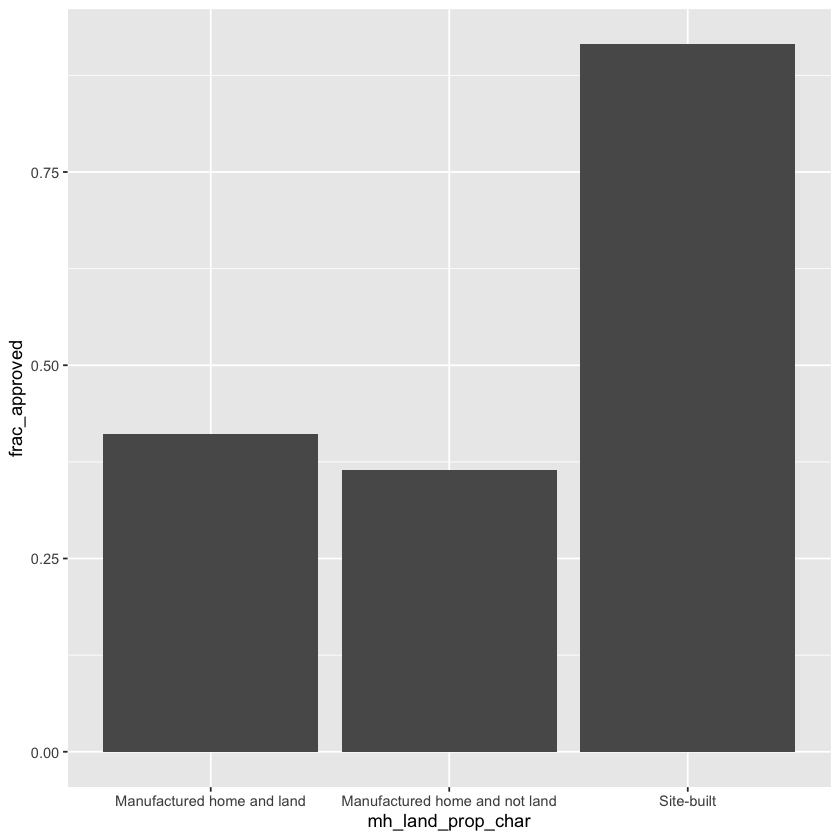

In [27]:
#-----------------------------------#
# Plot: Disparity in approval rates #
#-----------------------------------#

approval_disparity_mh_sb %>%
  ggplot(aes(x = mh_land_prop_char, y = frac_approved)) +
  geom_col()

Let's do some clean-up!

- Make it a horizontal bar graph.
- Highlight the categories we want to emphasize.
- Reorder by the bar height.
- Use percent instead of fractions.
- Add labels.
- Reduce the ink-to-data ratio.

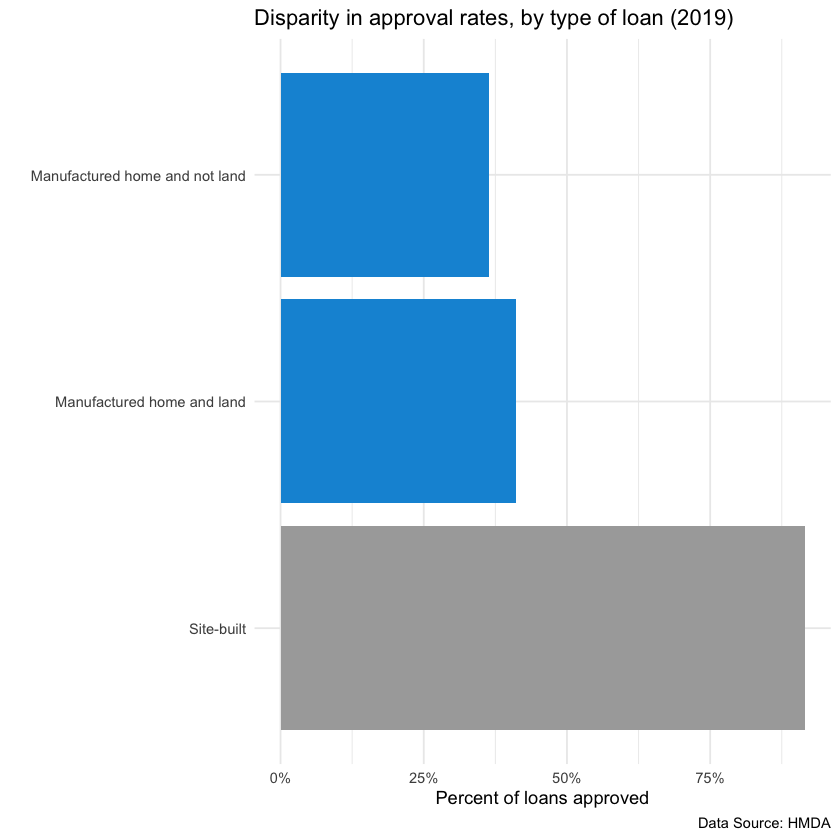

In [28]:
# Add additional details for a publication-style graph

approval_disparity_mh_sb %>%
filter(mh_land_prop_char != "Exempt") %>%
mutate(
    bar_color = (mh_land_prop_char == "Site-built")
) %>%
ggplot(
    aes(
        x = frac_approved,
        y = reorder(mh_land_prop_char, -frac_approved),
        fill = bar_color
    )
) +
geom_col() +
scale_x_continuous(labels = scales::percent) +
labs(
    title = "Disparity in approval rates, by type of loan (2019)",
    caption = "Data Source: HMDA",
    x = "Percent of loans approved",
    y = ""
) +
scale_fill_manual(
    values = c("#1295D8", "darkgray"),
    guide = FALSE
) +
theme_minimal()

## Maps: Choropleth

Another common graph you'll see is a choropleth. There are advantages and disadvantages to using this type of graph. You may find it helpful to think of [alternative ways](https://www.vox.com/2016/6/2/11828628/election-maps-hard) of plotting your data instead of using a map. Nonetheless, choropleths are a popular way to visualize your data. There are many ways to visualize a choropleth in R. We'll start with the easy situation first, which is to plot data for a common geographic level (e.g., county). We want to plot the manufactured home loan applications as a percent of total mortgage applications by county.

In [17]:
# Install and load package
if (!require("urbnmapr")) install.packages("urbnmapr")
library(urbnmapr)

Loading required package: urbnmapr



Let's prep our data.

In [18]:
#-----------------------------------------------------#
# Data Prep: Manfactured homes applications by county #
#-----------------------------------------------------#

# Calculate the percentage of mortgage applications that are manufactured homes
mh_by_ca_fips <- hmda %>%
  filter(state_code == "CA") %>%
  mutate(
    county_fips = substr(census_tract, 1, 5),
    mh = (dwelling_category == 1)
  ) %>%
  group_by(county_fips) %>%
  summarize(
      perc_mh = 100 * mean(mh),
      count_mh = sum(sum(!is.na(mh)))
)


Now let's prep our geographic data.

In [19]:
# Add geographic data elements
mh_by_ca_fips_sf <- get_urbn_map("counties", sf = TRUE) %>%
  filter(state_name == "California") %>%
  left_join(
    mh_by_ca_fips,
    by = "county_fips"
  )


Finally, our map!

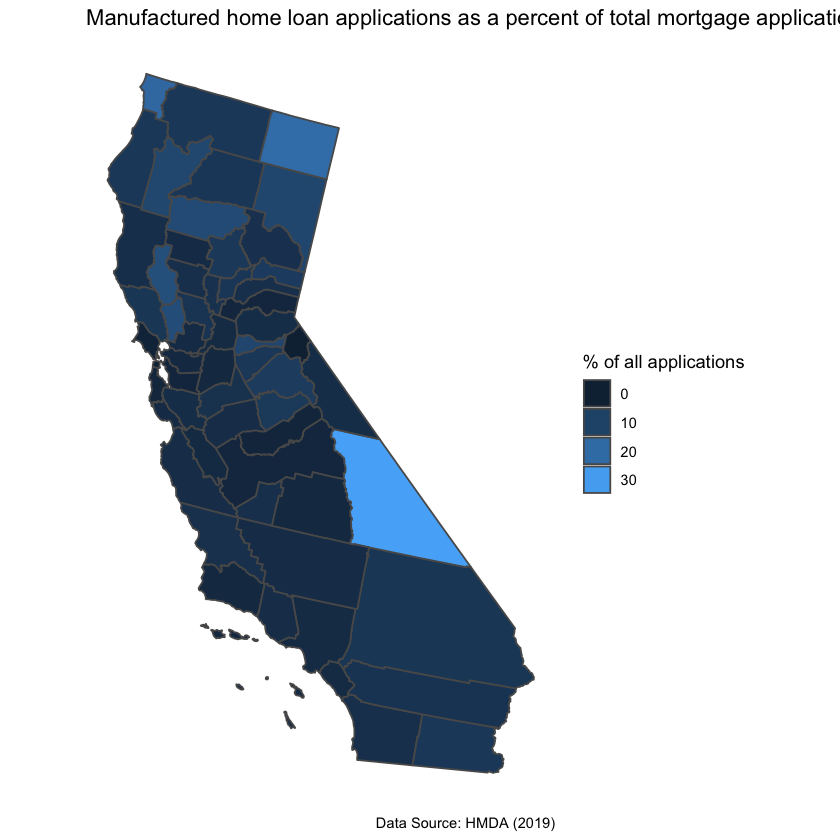

In [20]:
#-----------------------------------------------#
# Plot: Manfactured home applications by county #
#-----------------------------------------------#

mh_by_ca_fips_sf %>%
  ggplot(aes()) +
  geom_sf(aes(fill = perc_mh)) +
  coord_sf(datum = NA) +
  guides(fill = guide_legend(title = "% of all applications")) +
  labs(
    title = "Manufactured home loan applications as a percent of total mortgage applications, by county",
    caption = "Data Source: HMDA (2019)"
  ) +
  theme(panel.background = element_blank())